## FEDn API Example

This notebook provides an example of how to use the FEDn API to organize experiments and to analyze validation results. 

In [1]:
from fedn import APIClient
from fedn.dashboard.plots import Plot
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [2]:
DISCOVER_HOST = '127.0.0.1'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Initialize FEDn with a compute package and seed model from the mnist-pytorch example. Note that these files needs to be created separately by follwing instructions in the README of that example.

In [32]:
client.set_package('../mnist-pytorch/package.tgz', 'pytorchhelper')
client.set_initial_model('../mnist-pytorch/seed.npz')
seed_model = client.get_initial_model()

Next we start a training session:

In [31]:
session_config_fedavg = {
                    "helper": "numpyhelper",
                    "session_id": "experiment_fedavg",
                    "aggregator": "fedavg",
                    "model_id": seed_model['model_id'],
                    "rounds": 1
                 }

result_fedavg = client.start_session(**session_config_fedavg)

In [33]:
session_config_fedopt = {
                    "helper": "numpyhelper",
                    "session_id": "experiment_fedopt",
                    "aggregator": "fedopt",
                    "model_id": seed_model['model_id'],
                    "rounds": 10
                 }

result_fedopt = client.start_session(**session_config_fedopt)

In [50]:
models = client.list_models(session_id = "experiment_fedavg")

validations = []
acc = collections.OrderedDict()
for model in models["result"]:
    model_id = model["model"]
    #print(model_id)
    validations = client.list_validations(modelId=model_id)
    #print(validations.items(),'\n\n')

    for _ , validation in validations.items(): 
        metrics = json.loads(validation['data'])
        try:
            acc[model_id].append(metrics['training_accuracy'])
        except KeyError: 
            acc[model_id] = [metrics['training_accuracy']]
            
mean_acc_fedavg = []
for model, data in acc.items():
    mean_acc_fedavg.append(np.mean(data))
mean_acc_fedavg.reverse()

[0.36816665530204773, 0.45116665959358215, 0.5468333065509796, 0.7113333344459534, 0.7699166536331177, 0.8021666705608368, 0.823500007390976, 0.8380833268165588, 0.8509166836738586, 0.8634999990463257]


In [62]:
models = client.list_models(session_id = "experiment_fedopt2")

validations = []
acc = collections.OrderedDict()
for model in models["result"]:
    model_id = model["model"]
    #print(model_id)
    validations = client.list_validations(modelId=model_id)
    #print(validations.items(),'\n\n')
    for _ , validation in validations.items(): 
        metrics = json.loads(validation['data'])
        try:
            acc[model_id].append(metrics['training_accuracy'])
        except KeyError: 
            acc[model_id] = [metrics['training_accuracy']]
            
mean_acc_fedopt = []
for model, data in acc.items():
    mean_acc_fedopt.append(np.mean(data))
mean_acc_fedopt.reverse()

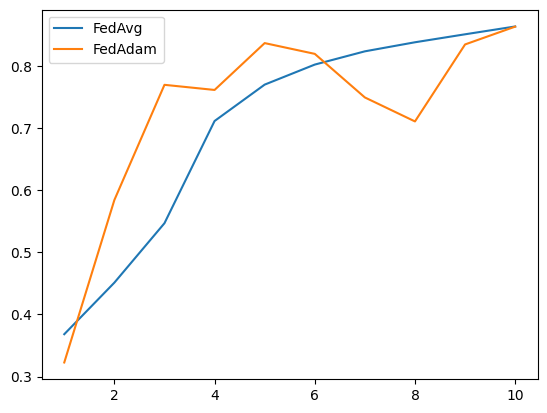

In [63]:
x = range(1,len(mean_acc_fedavg)+1)
plt.plot(x, mean_acc_fedavg, x, mean_acc_fedopt)
plt.legend(['FedAvg', 'FedAdam'])
#plt.plot(x,mean_acc_fedopt)